# 5. Modeling

## 5.1 Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import os

## 5.2 Load previously processed data

In [2]:
# Intermediate data was saved as '../data/baf_cat_dummy_na_median_num_scaled.csv.gz' previously.
baf_data = pd.read_csv('../data/baf_cat_dummy_na_median_num_scaled.csv.gz', compression='gzip')


In [3]:
# Validate data types and non-null values.
baf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993563 entries, 0 to 993562
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        993563 non-null  int64  
 1   email_is_free                     993563 non-null  int64  
 2   phone_home_valid                  993563 non-null  int64  
 3   phone_mobile_valid                993563 non-null  int64  
 4   has_other_cards                   993563 non-null  int64  
 5   foreign_request                   993563 non-null  int64  
 6   keep_alive_session                993563 non-null  int64  
 7   payment_type_AA                   993563 non-null  int64  
 8   payment_type_AB                   993563 non-null  int64  
 9   payment_type_AC                   993563 non-null  int64  
 10  payment_type_AD                   993563 non-null  int64  
 11  payment_type_AE                   993563 non-null  i

## 5.3 Split data into training and testing subsets

All the features will be used for modeling at the first step.

In [4]:
# split dataset into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(baf_data.drop(columns='fraud_bool'), baf_data.fraud_bool, test_size=0.3, random_state=47)

In [5]:
X_train.shape, X_test.shape

((695494, 52), (298069, 52))

In [6]:
y_train.shape, y_test.shape

((695494,), (298069,))

## 5.4 Applying the Machine Learning models

Fraud or not is a classification problem. The following supervised learning classification models will be used:

- Logistic Regression
- K-Nearest Neighbor (KNN)
- Random Forest
- Support vector machine (SVM)
- Naive Bayes
- Gradient Boost

For evaluation metrics, F1 score, Recall, Precision, ROC AUC, PR AUC will be calculated and compared.

In [7]:
# Import
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve


### 5.4.1 Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

# First we will try LogisticRegresssion model without considering the class_weight

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight=None, random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294774     26]
 [  3231     38]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.59      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.79      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.989073         0.59375     0.011624  0.022802   

  roc_auc_score    pr_auc  
0      0.871519  0.130022  


F1 score 0.022 is very poor. Would it be related to inbalanced classes?

In [9]:
# Print target column `fraud_bool` value count
print(baf_data['fraud_bool'].value_counts())
# Print the pencentage of fraud instances of all records
fraud_bool_1 = len(baf_data[baf_data['fraud_bool']==1]) / len(baf_data)
fraud_bool_0 = len(baf_data[baf_data['fraud_bool']==0]) / len(baf_data)
print(f'fraud_bool=1 of all ratio: {fraud_bool_1: .3f}')
print(f'fraud_bool=0 of all ratio: {fraud_bool_0: .3f}')

fraud_bool
0    982568
1     10995
Name: count, dtype: int64
fraud_bool=1 of all ratio:  0.011
fraud_bool=0 of all ratio:  0.989


We can see that the fraud ratio is very low, only 1.1% of all in baf_data. Next we are going to try class_weight='balanced' in the modeling.

In [10]:
# Try the built in class_weight='balanced'

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight='balanced', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[237182  57618]
 [   716   2553]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.80    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.80      0.88    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.804294        0.042429     0.780973  0.080485   

  roc_auc_score    pr_auc  
0      0.872572  0.125288  


With the built in 'balanced' class_weight, Recall score increased to 0.78, but Precision decreased to 0.04 as false positive number also increased a lot. F1 score improved to 0.08, better still poor. Accuracy score and roc_auc score doesn't seem to be good choices for inbalanced data classification in the current model. F1 score and pr_auc may be more useful metrics.

In [23]:
# Hyperparameter GridSearch for better parameters.
# penalty, C, class_weight, and solver will be tried.

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'class_weight': [{0:0.001, 1:0.999}, {0:0.005, 1:0.995}, {0:0.01, 1:0.99}, 
                               {0:0.02, 1:0.98}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}], 
              'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
              }

logreg = LogisticRegression(penalty='l2', random_state=47, max_iter=100000)

cv = GridSearchCV(logreg, param_grid, scoring='f1', cv=5, n_jobs=-1)
cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000, random_state=47),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [{0: 0.001, 1: 0.999},
                                          {0: 0.005, 1: 0.995},
                                          {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98}, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='f1')

In [24]:
print(f'Best score: {cv.best_score_}')
print(f'Best parameters: {cv.best_params_}')

Best score: 0.21037044297173818
Best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}


In [26]:
cv.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 0.1, 1: 0.9}, max_iter=100000,
                   random_state=47)

We will use the best parameters found by GridSearchCV to apply logistic regression model for result.

In [11]:
# Use best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight={0: 0.1, 1: 0.9}, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[290285   4515]
 [  2399    870]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    294800
           1       0.16      0.27      0.20      3269

    accuracy                           0.98    298069
   macro avg       0.58      0.63      0.59    298069
weighted avg       0.98      0.98      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.976804         0.16156     0.266136  0.201063   

  roc_auc_score    pr_auc  
0       0.87217  0.128743  


While F1 score is 0.201, Recall and Precision are both low. Let's visulize the result the ROC curve and Precision Recall curve.

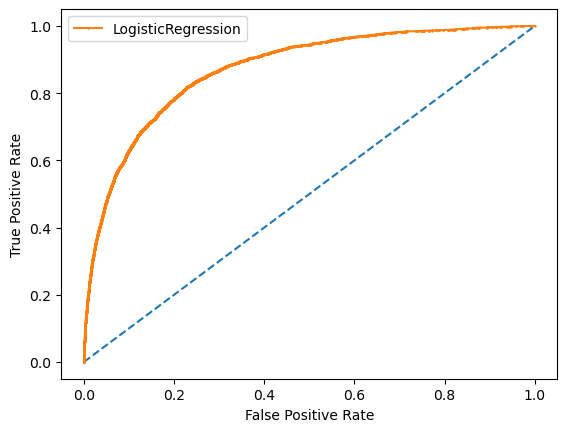

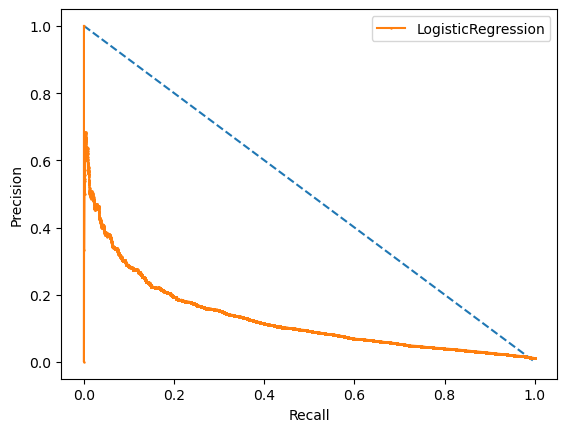

In [12]:
import matplotlib.pyplot as plt

fpr, tpr, thd = roc_curve(y_test, y_score)

# ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

From the above two charts, we can see that ROC curve doesn't show the impact of class inbalance. Precision recall curve may be better to use.

### 5.4.2 K-Nearest neighbor (KNN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

/home/ematrix/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[294800      0]
 [  3269      0]]


/home/ematrix/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ematrix/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.00      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.49      0.50      0.50    298069
weighted avg       0.98      0.99      0.98    298069

   n_neighbors Accuracy_score Precision_score Recall_score F1_score  \
0           50       0.989033             0.0          0.0      0.0   

  roc_auc_score    pr_auc  
0      0.770316  0.092424  


/home/ematrix/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It seems KNN modeling doesn't work well on the current data set. Is it possible for Recall and Precision bother to be 0? Need to discuss with Mentor and try different upsampling or different parameters with KNN and try again.

### 5.4.3 Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', random_state=47, n_jobs=-1, class_weight='balanced')
rfc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[294797      3]
 [  3263      6]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.67      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.83      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.989043        0.666667     0.001835  0.003661   

  roc_auc_score    pr_auc  
0      0.832728  0.127872  


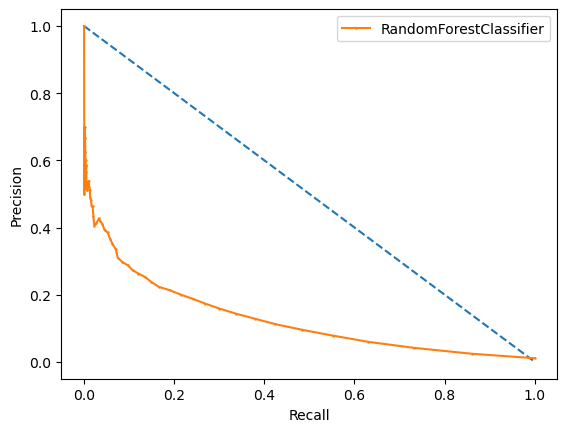

In [19]:
# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='RandomForestClassifier')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score

cv_scores_train= cross_val_score(rfc, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
# cv_scores_test= cross_val_score(rfc, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
print(f'cross validation train scores: {cv_scores_train}')
# print(f'cross validation test scores: {cv_scores_test}')
cv_scores_rf_train= cv_scores_train.mean()
# cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train_std= cv_scores_train.std()
# cv_scores_std_rf= cv_scores_test.std()
print (f'Mean cross validation train score: {cv_scores_rf_train}')
print (f'Standard deviation of cv train scores: {cv_scores_rf_train_std}')
# print (f'Mean cross validation test score: {cv_scores_rf_test}')


cross validation train scores: [0.00258398 0.00129366 0.00773694 0.00129116 0.00514801]
Mean cross validation train score: 0.0036107490056754336
Standard deviation of cv train scores: 0.0024976912126122267


When using F1 score as the metrics, the cross validation scores on train data varied with relatively big deviation.

### 5.4.4 Gradient Boost

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['GradientBoosting']

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, max_depth=10, random_state=47)
gbc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = gbc.predict(X_test)
y_score = gbc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[293355   1445]
 [  3068    201]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.12      0.06      0.08      3269

    accuracy                           0.98    298069
   macro avg       0.56      0.53      0.54    298069
weighted avg       0.98      0.98      0.98    298069

              model Accuracy_score Precision_score Recall_score F1_score  \
0  GradientBoosting       0.984859        0.122114     0.061487  0.08179   

  roc_auc_score    pr_auc  
0      0.877752  0.089802  


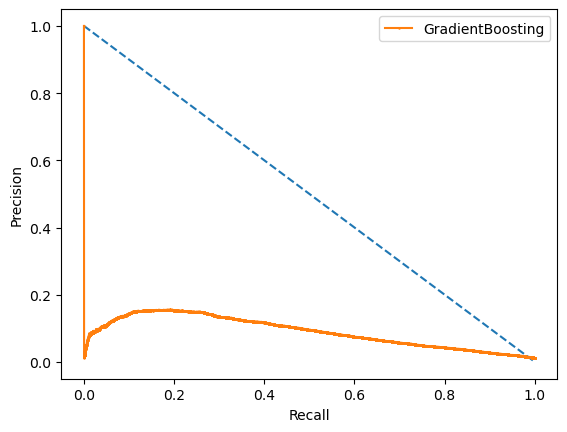

In [24]:
# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='GradientBoosting')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

In [23]:

cv_scores_train= cross_val_score(gbc, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
# cv_scores_test= cross_val_score(gbc, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
print(f'cross validation train scores: {cv_scores_train}')
# print(f'cross validation test scores: {cv_scores_test}')
cv_scores_rf_train= cv_scores_train.mean()
# cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train_std= cv_scores_train.std()
# cv_scores_std_rf= cv_scores_test.std()
print (f'Mean cross validation train score: {cv_scores_rf_train}')
print (f'Standard deviation of cv train scores: {cv_scores_rf_train_std}')
# print (f'Mean cross validation test score: {cv_scores_rf_test}')

cross validation train scores: [0.0793177  0.07705479 0.07017544 0.07839795 0.08490963]
Mean cross validation train score: 0.07797110221487549
Standard deviation of cv train scores: 0.0047275918429300545
